### Fall 2019, Machine Learning and Predictive Analytics 

In [60]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sci-kit learn linear regression library
from sklearn.linear_model import LinearRegression

# Importing some of my preferred plotting settings
# Feel free to change, adapt
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 3




**In I am going to explore adding and removing capacity from a Machine Learning model** 

Specifically, I will modify the linear regression gradient descent algorithm from old code to include regularization.  We will then use that linear model to fit non-linear data utilizing polynomial features (to add capacity and reduce under-fitting). Following that, we will add regularization (to remove capacity and reduce overfitting).  In the end, a balance between the two will provide a good solution.


**Let's start with the data we'll analyze**

We'll use a ReLU functional form (stolen from neural networks) since it is inherently non-linear.  We'll generate some synthetic data and add some gaussian noise to the distribution.


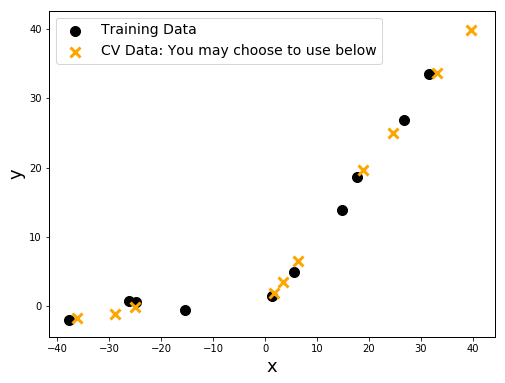

In [78]:
np.random.seed(101)

def relu(v):
    return np.maximum(0, v) 
    
    
x = np.sort(np.random.uniform(-40, 40, 10))
y = 0. + relu(x) + 1.*np.random.randn(x.size)

# You may choose to use an external cross validation dataset in the exercises below
# This can be generated here:
x_cv = np.random.uniform(-40, 40, 10)
y_cv = 0. + relu(x_cv) + 1.*np.random.randn(x_cv.size)
    
# Visualize the data
plt.figure(figsize=(8,6))
plt.scatter(x, y, color="black", s=100, label="Training Data")
plt.scatter(x_cv, y_cv, color="orange", marker="x", s=100, label="CV Data: You may choose to use below")
plt.xlabel("x", fontsize=18)
plt.ylabel("y", fontsize=18);
plt.legend(fontsize=14);




## Define the functional form of Regularized GD

I can start from the functions defined in previous code and add the Ridge regularization term to the cost and gradients.  Recall that regularized linear regression looks like this:

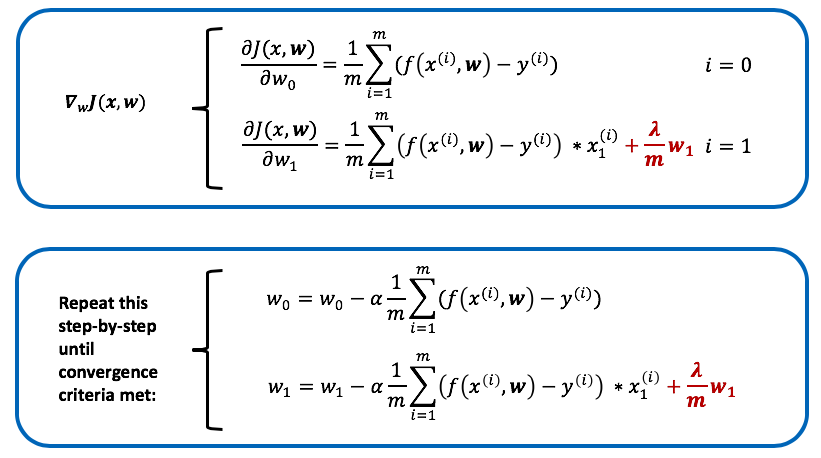

This can be performed via a loop, but also has a vectorized form if we add a column of '1's to the x matrix.  The vectorized version then takes the form 

$\nabla_{w}(J(x,w)) = {1\over{m}} \bf{x}^{T}(\bf{xw}-y) + {\lambda\over{m}}*w$.

Implement the gradient descent step in the updateParameters function below.

$\bf{Note}$ that if you choose to use the vectorized form, you'll want to add a column of 1's to the x vector so that it can be used in a dot product.

In [79]:

def updateParameters(thesePars, x_examples, y_examples, alpha, mylambda):
    
    m = len(x_examples)

    grad = x_examples.T.dot( x_examples.dot(thesePars) - y_examples )
    thesePars = thesePars - (alpha/m) * grad    
    
    regterm = ((mylambda/m)*(thesePars))
    regterm[0] = 0

    return thesePars+regterm

def calculateLoss(y_pred, y_true, thesePars, mylambda):

    if len(y_pred) != len(y_true):
        print("Problem y_true != y_pred")
        return False    

    m = len(y_true)
    
    loss = 1/(2*len(y_pred))
    for ind, val in enumerate(y_pred):
        loss += np.power(val - y_true[ind], 2)

    # FILL IN THE REGULARIZATION TERM IN THE LOSS FUNCTION HERE
    regterm = ((mylambda/m)*(thesePars))
    regterm[0] = 0
    
    return loss+regterm
        
def runGradientDescent(X, Y, pars, nIterations, alpha, mylambda):
   
    loss = []
    pars_history = []
    pars_history.append(pars.copy())

    # Save the initial loss     
    thisY = pars.dot(X.T)
    loss.append(calculateLoss(thisY, Y, pars, mylambda))
    
    for i in range(nIterations):
        pars = updateParameters(pars, X, Y, alpha, mylambda)          
        thisY = pars.dot(X.T)
        loss.append(calculateLoss(thisY, Y, pars, mylambda))
        pars_history.append(pars.copy())
    
    return loss, pars, pars_history

In [80]:

# Set some intial parameters
np.random.seed(10)
initialP = np.random.randn(2)
print("Starting parameters:", initialP)
alpha = 0.002
numIterations = 10000
mylambda = 1

x_b = np.c_[np.ones((x.shape[0], 1)), x]  # add x0 = 1 to each instance

# Run Gradient Descient
final_loss, final_pars, pars_history = runGradientDescent(x_b, y, initialP, numIterations, alpha, mylambda)
print("Final parameters:", final_pars)


Starting parameters: [1.3315865  0.71527897]
Final parameters: [10.13519816  0.51364458]


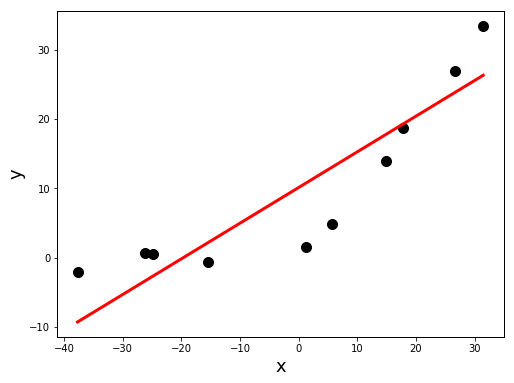

In [81]:

# We can then plot the result to visualize

xModelOut = np.linspace(min(x), max(x), 100)
yModelOut = final_pars[0] + xModelOut * final_pars[1]
plt.figure(figsize=(8,6))
plt.scatter(x, y, color="black", s=100)
plt.plot(xModelOut, yModelOut, color="red")
plt.xlabel("x", fontsize=18)
plt.ylabel("y", fontsize=18);

In [65]:
#No myLambda can change the slope but won't allowed non-linearity as it's don't add polynomial  

## Confirm results with the sci-kit learn implementation of Linear Regression

In [82]:
np.random.seed(109)
from sklearn.linear_model import Ridge
lin_reg = Ridge(alpha=1)
lin_reg.fit(x.reshape(-1, 1),  y)
print(lin_reg.intercept_, lin_reg.coef_)
lin_reg = Ridge(alpha=0)
lin_reg.fit(x.reshape(-1, 1),  y)
lin_reg.intercept_, lin_reg.coef_

10.105992313666418 [0.46896102]


(10.106050859416735, array([0.46905059]))


The main idea of a learning curve is to loop over the training data.  For each training example you:
- Train a model with the current training example all the examples that sequentially came before it
- Assess the performance on the training examples used to train the model this iteration (Use Mean Squared Error)
- Assess the performance on the full cross-validation (or hold-out) dataset (Use Mean Squared Error)
- Plot this as a function of training example


In this assignment, you can choose to use the gradient descent algorithm you generated above OR simply use Linear Regression from sci-kit learn. Either will be accepted.

In [84]:

# Possible imports if you use the sci-kit learn approach, or want a single call to calculate the error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curve(lin_reg, X, y):
    
    print(X.shape, y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
    train_errors = []
    test_errors = []  
    for m in range(1, len(X_train)):
        x_train_new = X_train[:m]
        y_train_new = y_train[:m]
        # Now, save the values for this subsample of data
        model = lin_reg #Ridge(alpha = 0)
        model.fit(x_train_new, y_train_new)
        y_pred_train = model.predict(x_train_new)
        y_pred_test = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train_new, y_pred_train))
        test_errors.append(mean_squared_error(y_test, y_pred_test))  


    print("Final Cross Validation Error:",np.sqrt(test_errors[-1]))        
        
    plt.plot(np.sqrt(train_errors), "black", label="train")
    plt.plot(np.sqrt(test_errors), "orange", linestyle="--", label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

(10, 1) (10, 1)
Final Cross Validation Error: 6.486818357763379


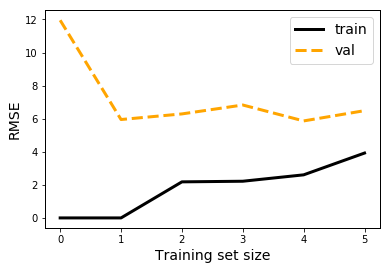

In [85]:

plot_learning_curve(LinearRegression(), x.reshape(-1,1), y.reshape(-1,1))



The plot above suggests that our model is underfit and would benefit from adding more capacity / complexity.  In other words it is too simple.  We are going to fix this by adding polynomial features.

The new functional form we are fitting would then be (building off the existing 1-D x feature already there):

$f(x,w) = w_{0} + w_{1}*x + w_{2}*x^{2} + w_{3}*x^{3} + ... $


### I added polynomial features to the feature vector to add some additional weights parameters for linear regression to consider.  Start with features up to degree 8.  Rerun Linear Regression and plot the results.




In [86]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler  # or use the code we used in HW1 to standardize

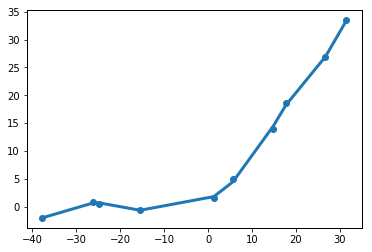

In [87]:
poly = PolynomialFeatures(degree=8, include_bias=False)
x_poly = poly.fit_transform(x_b[:,1].reshape(-1,1))
model = LinearRegression().fit(x_poly, y)
yfit = model.predict(x_poly)
plt.scatter(x_b[:,1], y)
plt.plot(x_b[:,1], yfit);



It seems that we have over-compensated by adding features up to degree 8.  There are lots of wiggles and curves in the fit that don't seem data-driven.

### Plot the learning curve for this model below

(10, 8) (10,)
Final Cross Validation Error: 172.2177517334068


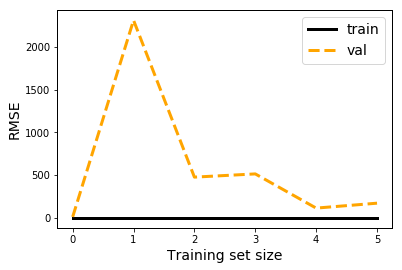

In [88]:
plot_learning_curve(LinearRegression(), x_poly, y)

## Now, I utilized the regularized model you built above and/or Ridge Regression from scikit learn to regularize the model.

## Test several values of the regularization coefficient alpha and find a model that performs better than without any regularization.


(10, 1) (10,)
Final Cross Validation Error: 6.488428860888674


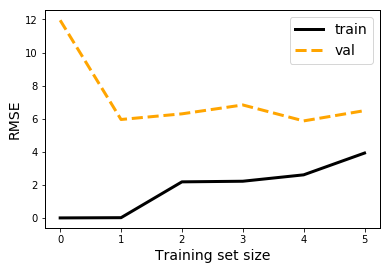

In [89]:
plot_learning_curve(Ridge(alpha = .9), x.reshape(-1, 1), y)

(10, 1) (10, 1)
Final Cross Validation Error: 6.488249933596999


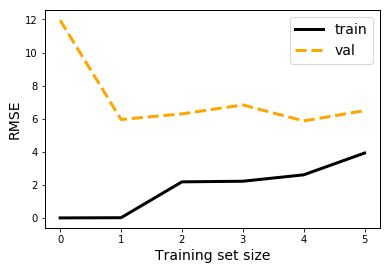

In [90]:
plot_learning_curve(Ridge(alpha = 0.8), x.reshape(-1, 1), y.reshape(-1,1))

(10, 1) (10, 1)
Final Cross Validation Error: 6.487713125457618


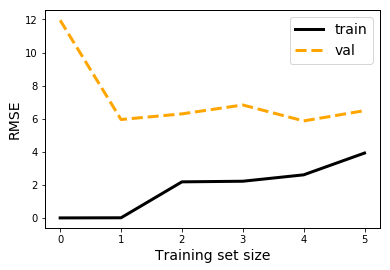

In [91]:
plot_learning_curve(Ridge(alpha = 0.5), x.reshape(-1, 1), y.reshape(-1,1))

(10, 1) (10, 1)
Final Cross Validation Error: 6.487355231492046


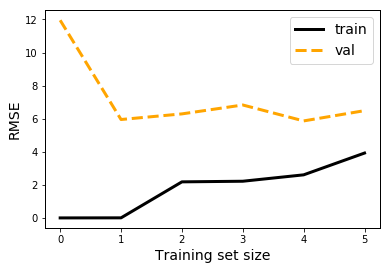

In [92]:
plot_learning_curve(Ridge(alpha = 0.3), x.reshape(-1, 1), y.reshape(-1,1))
#the best

(10, 1) (10, 1)
Final Cross Validation Error: 6.486997320041731


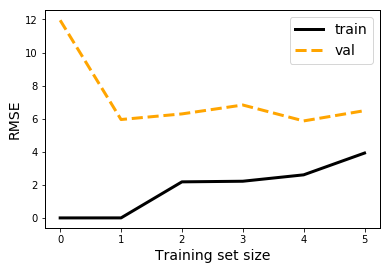

In [93]:
plot_learning_curve(Ridge(alpha = 0.1), x.reshape(-1, 1), y.reshape(-1,1))

(10, 1) (10, 1)
Final Cross Validation Error: 6.486961527935482


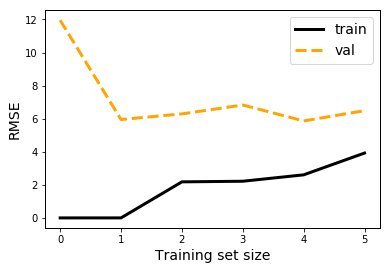

In [94]:
plot_learning_curve(Ridge(alpha = 0.08), x.reshape(-1, 1), y.reshape(-1,1))